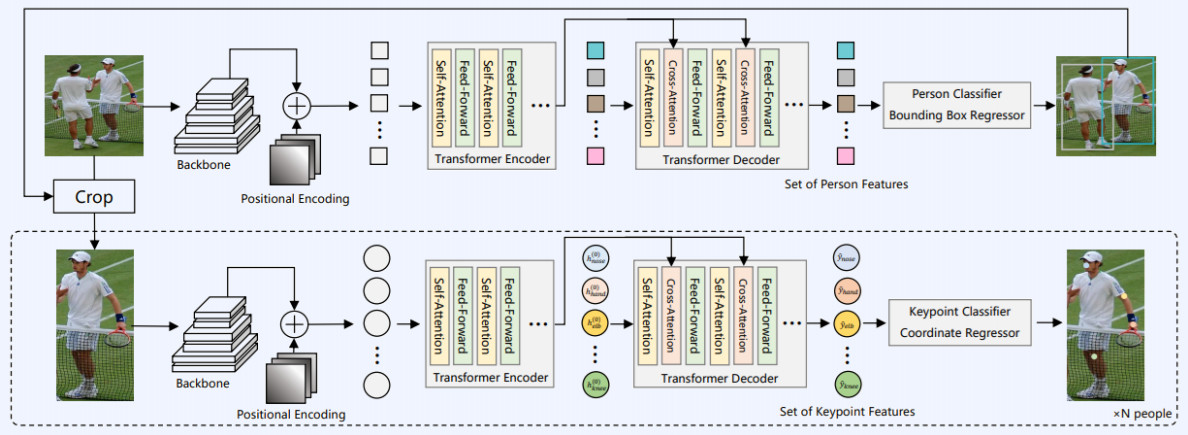

In [4]:
from IPython.display import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, random
from scipy.optimize import linear_sum_assignment
from utils import NestedTensor, nested_tensor_from_tensor_list, MLP
    
Image(filename="../figures/Cap_2022-07-26_22-39-29-277.jpg", retina=True)

This notebook provides a Pytorch implementation for the sequential variant of PRTR (Pose Regression TRansformers) in [Pose Recognition with Cascade Transformers](https://arxiv.org/abs/2104.06976).     

It is intended to provide researchers interested in sequential PRTR with a concrete understanding that only code can deliver. It can also be used as a starting point for end-to-end top-down pose estimation research.

In [5]:
class PRTR_sequential(nn.Module):
    def __init__(self, backbone, transformer, transformer_kpt, level, x_res=10, y_res=10):
        super().__init__()
        self.backbone = backbone
        self.transformer = transformer
        hidden_dim = transformer.d_model
        self.class_embed = nn.Linear(hidden_dim, 2)
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)
        self.query_embed = nn.Embedding(100, hidden_dim)
        self.input_proj = nn.Conv2d(backbone.num_channels, hidden_dim, kernel_size=1)
        self.transformer_kpt = transformer_kpt
        x_interpolate = torch.linspace(-1.25, 1.25, x_res, requires_grad=False).unsqueeze(0)  # [1, x_res], ANNOT ?(1)
        y_interpolate = torch.linspace(-1.25, 1.25, y_res, requires_grad=False).unsqueeze(0)  # [1, y_res]
        self.register_buffer("x_interpolate", x_interpolate)
        self.register_buffer("y_interpolate", y_interpolate)
        self.x_res = x_res
        self.y_res = y_res
        self.level = level
        mask = torch.zeros(1, y_res, x_res, requires_grad=False)  # [1, y_res, x_res]
        self.register_buffer("mask", mask)
        self.build_pe()

Class `PRTR_sequential` needs the following arguments:
+ backbone: a customizable CNN backbone which returns a pyramid of feature maps with different spatial size
+ transformer: a customizable Transformer for person detection (1st Transformer)
+ transformer_kpt: a customizable Transformer for keypoint detection (2nd Transformer)
+ level: from which layers of pyramid we will extract features
+ x_res: the width of STN-cropped featrure map fed to 2nd Transformer
+ y_res: the height of STN-cropped featrure map fed to 2nd Transformer

Some annotations:
1. For `x_interpolate` and `y_interpolate`, we use an extended eyesight of 125% to the orginal boudning box to provide more information from backbone to the 2nd Transformer.

In [6]:
    def build_pe(self):
        # fixed sine pe
        not_mask = 1 - self.mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)

        eps = 1e-6; scale = 2 * math.pi  # normalize?
        y_embed = y_embed / (y_embed[:, -1:, :] + eps) * scale
        x_embed = x_embed / (x_embed[:, :, -1:] + eps) * scale

        num_pos_feats = 128; temperature = 10000
        dim_t = torch.arange(num_pos_feats, dtype=torch.float32, device=self.mask.device)
        dim_t = temperature ** (2 * (dim_t // 2) / num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        self.register_buffer("pe", pos)

        # learnable pe
        self.row_embed = nn.Embedding(num_pos_feats, self.x_res)
        self.col_embed = nn.Embedding(num_pos_feats, self.y_res)
        nn.init.uniform_(self.row_embed.weight)
        nn.init.uniform_(self.col_embed.weight)

    def get_leant_pe(self):
        y_embed = self.col_embed.weight.unsqueeze(-1).expand(-1, -1, self.x_res)
        x_embed = self.row_embed.weight.unsqueeze(1).expand(-1, self.y_res, -1)
        embed = torch.cat([y_embed, x_embed], dim=0).unsqueeze(0)
        return embed

PRTR_sequential.build_pe = build_pe
PRTR_sequential.get_leant_pe = get_leant_pe

Then we build positional embedding for the 2nd Transformer, which ensembles both fixed sinusoidal embedding and learnt embedding.  
For each box containing person cropped from original image, we use the same positional embedding, irrelevent to where the box is.

In [8]:
    def forward(self, samples):
        # the 1st Transformer, to detect person
        features, pos = self.backbone(samples)
        hs = self.transformer(self.input_proj(features[-1].tensors), features[-1].mask, self.query_embed.weight, pos[-1])[0][-1]  # [B, person per image, f]
        logits = self.class_embed(hs)  # [B, person per image, 2]
        bboxes = self.bbox_embed(hs).sigmoid()  # [B, person per image, 4]
        outputs = {'pred_logits': logits, 'pred_boxes': bboxes}

        # some preperation for STN feature cropping
        person_per_image = hs.size(1)
        num_person = person_per_image * hs.size(0)
        heights, widths = samples.get_shape().unbind(-1)  # [B] * 2
        rh = heights.repeat_interleave(person_per_image)  # [person per image * B]
        rw = widths.repeat_interleave(person_per_image)  # [person per image * B]
        srcs = [features[_].decompose()[0] for _ in self.level]
        cx, cy, w, h = bboxes.flatten(end_dim=1).unbind(-1)  # [person per image * B] * 4
        cx, cy, w, h = cx * rw, cy * rh, w * rw, h * rh  # ANNOT (1)

        # STN cropping
        y_grid = (h.unsqueeze(-1) @ self.y_interpolate + cy.unsqueeze(-1) * 2 - 1).unsqueeze(-1).unsqueeze(-1)  # [person per image * B, y_res, 1, 1]
        x_grid = (w.unsqueeze(-1) @ self.x_interpolate + cx.unsqueeze(-1) * 2 - 1).unsqueeze(-1).unsqueeze(1)  # [person per image * B, 1, x_res, 1]
        grid = torch.cat([x_grid.expand(-1, self.y_res, -1, -1), y_grid.expand(-1, -1, self.x_res, -1)], dim=-1)
        cropped_feature = []
        cropped_pos = []
        for j, l in enumerate(self.level):
            cropped_feature.append(F.grid_sample(srcs[j].expand(num_person, -1, -1, -1), grid, padding_mode="border"))  # [person per image * B, C, y_res, x_res]
        cropped_feature = torch.cat(cropped_feature, dim=1)
        cropped_pos.append(self.pe.expand(num_person, -1, -1, -1))
        cropped_pos.append(self.get_leant_pe().expand(num_person, -1, -1, -1))
        cropped_pos = torch.cat(cropped_pos, dim=1)
        mask = self.mask.bool().expand(num_person, -1, -1)  # ANNOT (2)
        
        # 2nd Transformer
        coord, logtis = self.transformer_kpt(bboxes, cropped_feature, cropped_pos, mask)  # [person per image * B, 17, 2]

        outputs["pred_kpt_coord"] = coord.reshape(hs.size(0), -1, self.transformer_kpt.num_queries, 2)
        outputs["pred_kpt_logits"] = logtis.reshape(hs.size(0), -1, self.transformer_kpt.num_queries, self.transformer_kpt.num_kpts + 1)
        return outputs

PRTR_sequential.forward = forward

`forward` method takes in a `NestedTensor` and returns a dictionary of predictions, some annotations:
1. Input `samples` and `features` are `NestedTensor`, which basically stacks a list of tensors of different shapes by their top-left corner and uses masks to denote valid positions. Thus when we need to crop person bounding boxes from the whole feature map, we need to scale boxes according to image size
2. we always gives unmasked image to the 2nd Transformer, becasue all the persons are cropped to the same resolution

In [7]:
    def infer(self, samples):
        self.eval()
        outputs = self(samples)
        out_logits, out_coord = outputs['pred_kpt_logits'], outputs['pred_kpt_coord']

        C_stacked = out_logits[..., 1:].transpose(2, 3).flatten(0, 1).detach().cpu().numpy()  # [person per image * B, 17, num queries (for keypoint)]
        out_coord = out_coord.flatten(0, 1)
        coord_holder = []
        for b, C in enumerate(C_stacked):
            _, query_ind = linear_sum_assignment(-C)
            coord_holder.append(out_coord[b, query_ind.tolist()])
        matched_coord = torch.stack(coord_holder, dim=0).reshape(out_logits.size(0), out_logits.size(1), 17, -1)
        return matched_coord  # [B, num queries, num kpts, 2]

PRTR_sequential.infer = infer

`infer` takes the same input as `forward`, but instead of returning all keypoint queries for loss calculaiton, it leverages a Hungarian algorithm to select the 17 keytpoints as prediction.  
The selection process can be thought of as a bipartite graph matching problem, graph constructed as below:
+ for each query in 2nd Transformer a node is made, creating set Q
+ for each keypoint type, a node is made, creating set K
+ set Q and K are fully inter-connected, edge weight between $Q_i$ and $K_j$ are the _unnormalized logits_ of query $i$ classified as keypoint type $k$
+ Q, K have no intra-connection, 

Hungarian algorithm will find the matching between Q and K with highest edge weights, selected queries are returned as prediction. A minimal example with only 3 queries and 2 keypoint types are shown as below:

![](figs/readout.png)

In [9]:
class DETR_kpts(nn.Module):
    def __init__(self, transformer, num_kpts, num_queries, input_dim):
        super().__init__()
        self.num_kpts = num_kpts
        self.num_queries = num_queries
        hidden_dim = transformer.d_model
        self.query_embed = nn.Embedding(num_queries, hidden_dim)
        self.input_proj = nn.Conv2d(input_dim, hidden_dim, kernel_size=1)
        self.transformer = transformer
        self.coord_predictor = MLP(hidden_dim, hidden_dim, 2, num_layers=3)
        self.class_predictor = nn.Linear(hidden_dim, num_kpts + 1)

    def forward(self, bboxes, features, pos, mask):
        src_proj = self.input_proj(features)
        j_embed = self.transformer(src_proj, mask, self.query_embed.weight, pos)[0][-1]  # [B, num queries, hidden dim]
        j_coord_ = self.coord_predictor(j_embed).sigmoid()
        x, y = j_coord_.unbind(-1)  # [B, Q] * 2
        x = (x * 1.25 - 0.625) * bboxes[:, 2].unsqueeze(-1) + bboxes[:, 0].unsqueeze(-1)
        y = (y * 1.25 - 0.625) * bboxes[:, 3].unsqueeze(-1) + bboxes[:, 1].unsqueeze(-1)
        x = x.clamp(0, 1)
        y = y.clamp(0, 1)
        j_coord = torch.stack([x, y], dim=-1)
        j_class = self.class_predictor(j_embed[-1])  # [B, J, c+1], logits
        return j_coord, j_class

Class `DETR_kpts` is the 2nd Transformer in PRTR and needs the following arguments:
+ transformer: a customizable Transformer for keypoint detection (2nd Transformer)
+ num_kpts: number of keypoint annotations per person of this dataset, e.g., COCO has 17 keypoints
+ num_queries: query number, similar to DETR
+ input_dim: image feature dimension from 1st Transformer

Its `forward` takes in `bboxes` becasue we need to recover per-person prediction to whole image coordinates, `features`, `pos` and `mask` for Transformer input.  
`forward` returns predicted keypoint coordinates in 0 to 1, relative to whole image, and their probability belonging to each keypoint class, e.g. nose, left shoulder.